In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO
from sklearn import tree
import graphviz 
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

sns.set(rc={'figure.figsize':(4,2)})

1) Load in the dataset https://d1pqsl2386xqi9.cloudfront.net/notebooks/Default.csv into a pandas dataframe

2) Convert default and student to categorical variables.

In [2]:
data = pd.read_csv("hw3data.csv")
data = data.drop(columns="Unnamed: 0")
data = data.replace("No", 0).replace("Yes", 1)
data.head()

,default,student,balance,income
0,0,0,729.526495,44361.62507
1,0,1,817.180407,12106.13470
2,0,0,1073.549164,31767.13895
3,0,0,529.250605,35704.49394
4,0,0,785.655883,38463.49588


3) Make boxplots of all of the variables and a scatter plot of of (balance,income) with the color of the outcome of default labeled red if yes and blue if no.

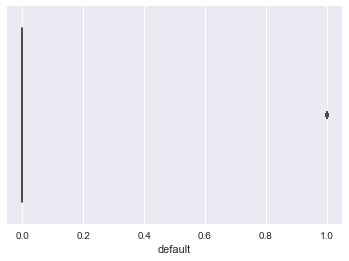

In [3]:
bx_default = sns.boxplot(x=data["default"])

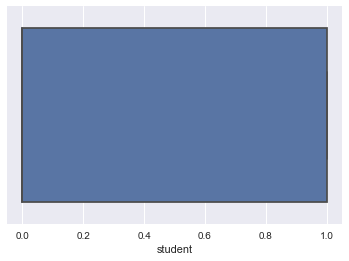

In [4]:
bx_student = sns.boxplot(x=data["student"])

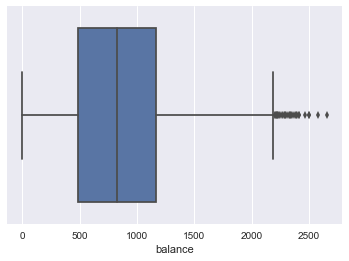

In [5]:
bx_balance = sns.boxplot(x=data["balance"])

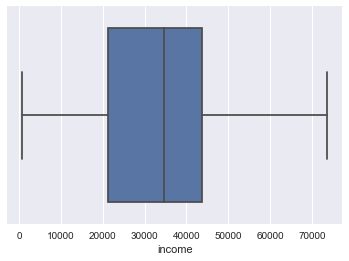

In [6]:
bx_income = sns.boxplot(x=data["income"])

4) Train a model to predict if a student defaults on their loan or not using LogisticRegression based soley on the balance and income variables. Plot the decision boundary in the scatter plot you made in 3) and compute the AUC ROC.

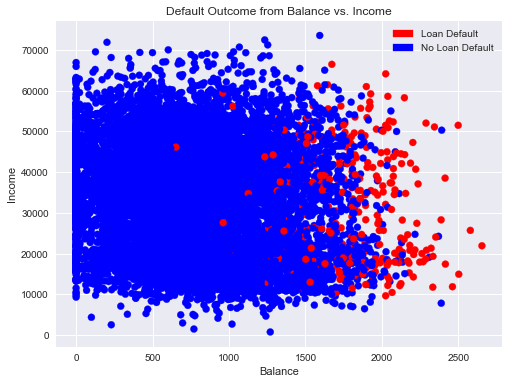

In [7]:
#Specify default plot sizing
sns.set(rc={'figure.figsize':(8,6)})

#Specify color mapping for scatter plot
colors = {0:"blue",1:"red"}

#Specify legend colors using patches
red_patch = mpatches.Patch(color='red', label='Loan Default')
blue_patch = mpatches.Patch(color='blue', label='No Loan Default')

#Scatter plot
plt.scatter(x=data["balance"], y=data["income"], c=data["default"].apply(lambda x:colors[x]))
plt.title("Default Outcome from Balance vs. Income")
plt.xlabel("Balance")
plt.ylabel("Income")
plt.legend(handles=[red_patch, blue_patch])

plt.show()

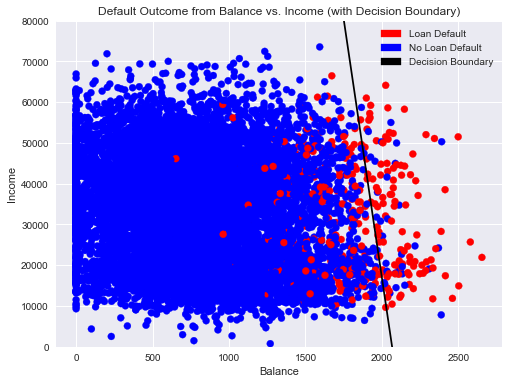

In [8]:
#Specify x and y data
X = data[["balance","income"]]
y = data["default"]

#Split data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2)

#Train model
model = LogisticRegression(penalty = "l1")
fit = model.fit(X_train,y_train)

#Specify legend colors for decision boundary
black_patch = mpatches.Patch(color='black', label='Decision Boundary')

#Scatter Plot
plt.scatter(x=data["balance"], y=data["income"], c=data["default"].apply(lambda x:colors[x]))
plt.title("Default Outcome from Balance vs. Income (with Decision Boundary)")
plt.xlabel("Balance")
plt.ylabel("Income")
plt.legend(handles=[red_patch, blue_patch, black_patch])

#Calculate Decision Boundary
b = fit.intercept_
coef = fit.coef_[0]

x = np.arange(0, 2600, 1)
y = (b + coef[0] * x) / (-coef[1])

#Plot boundary
plt.plot(x, y, color='black')
plt.ylim(0, 80000)
plt.show()

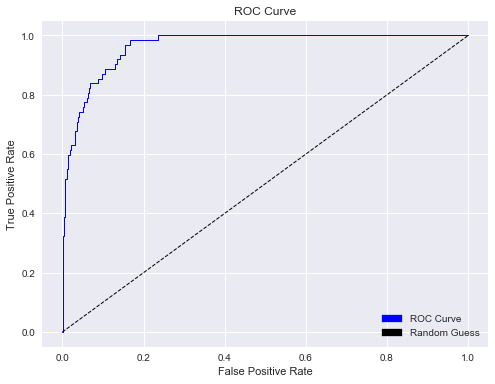

Area under the ROC curve: 0.9642714471187456


In [9]:
def get_auc(X,y,fit):
    prob = fit.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, prob[:, 1])
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

fpr, tpr, thresholds, roc_auc = get_auc(X_test,y_test,fit)


#Specify legend colors
roc_curve_patch = mpatches.Patch(color='blue', label='ROC Curve')
random_guess_patch = mpatches.Patch(color='black', label='Random Guess')

plt.plot(fpr, tpr, lw=1, color='blue')
plt.plot([0, 1], [0, 1],  linestyle='--',lw=1, color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(handles=[roc_curve_patch, random_guess_patch], loc="lower right")
plt.show()

print ("Area under the ROC curve:", roc_auc)


5) Repeat 4) but with the student variable included. Optimize using Ridge regression and plot the ranking of coefficients. How does performance improve with the added variable?

Performance barely improves - in fact, it appears to get slightly worse with the added variable. This indicates that the added variable probably adds little value to the model, and in fact with the extra, essentially useless information it makes it harder for the model to predict default rates.

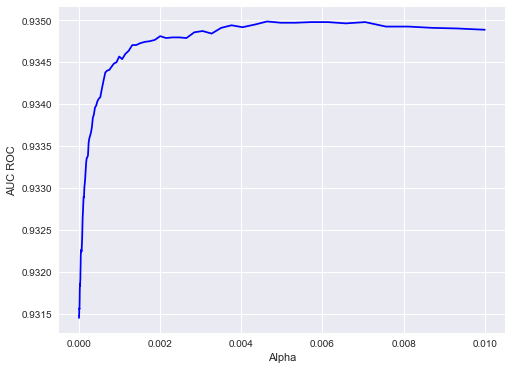

Optimal alpha: 0.004641588833612782


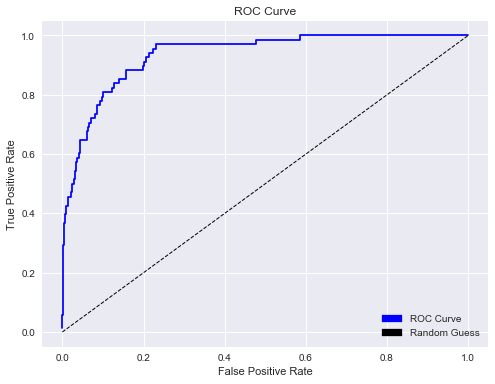

Area under the ROC curve: 0.9348891730605285


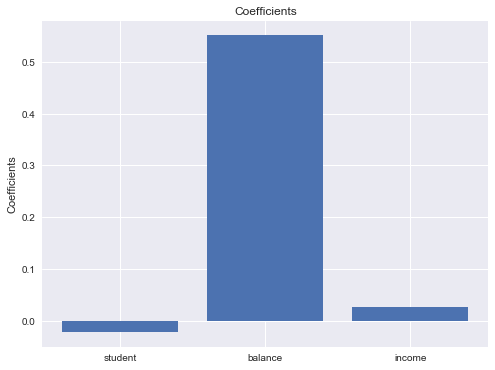

Coefficients:  [-0.02130149  0.55060587  0.02765126]


In [10]:
#Add student variable to the data
X = data[["student","balance","income"]]
y = data["default"]

#Split data
x = StandardScaler().fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2, random_state=10)

alphas = np.logspace(-5,-2,100)
score = []

#Calculate the optimal alpha to use
for alpha in alphas:
    regr = LogisticRegression(C=alpha, penalty='l2')
    probas_ = regr.fit(x_train, y_train).predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    roc_auc = auc(fpr, tpr)
    score.append(roc_auc)
alpha_max_score = alphas[np.argmax(score)]

#Plot alphas to see how they improve over time
plt.plot(alphas, score, color='blue')
plt.xlabel('Alpha')
plt.ylabel('AUC ROC')
plt.show()
print("Optimal alpha:", alpha_max_score)


#Regression
regr = LogisticRegression(C=alpha_max_score, penalty='l2')
regr.fit(x_train, y_train)


#Plot ROC
plt.plot(fpr, tpr, color='blue')
plt.plot([0, 1], [0, 1],  linestyle='--',lw=1, color='black')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(handles=[roc_curve_patch, random_guess_patch], loc="lower right")
plt.show()
print ("Area under the ROC curve:", roc_auc)

# Plot coefficients
fig, ax = plt.subplots()
ax.bar(np.linspace(0,2,3),regr.coef_[0])
ax.set_ylabel('Coefficients')
ax.set_title('Coefficients')
ax.set_xticks(np.arange(3))
ax.set_xticklabels(('student', 'balance', 'income'))

plt.show()

print("Coefficients: ", *regr.coef_)


6) Using cross validation, check that the model you built in 5) is robust (generalizes to other random folds of the dataset).

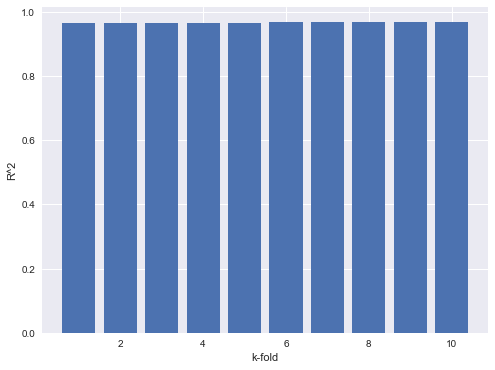

Score for different folds: [0.96629213 0.96629213 0.96629213 0.96629213 0.96629213 0.96745932
 0.96745932 0.96745932 0.96745932 0.96745932]


In [11]:
scores = cross_val_score(regr, X_train, y_train, cv=10)
plt.xlabel('k-fold')
plt.ylabel('R^2')
plt.bar(range(1,11),scores)
plt.show()
print("Score for different folds:",scores)

Since the scores are all very similar, it suggests that the model is quite robust.

7) Train a Decision Tree classifier with maximum depth 5 and plot the decision tree. How does performance compare?

Performance is slightly worse. In the plot below where we can see the performance of decisions trees from depths 1-20, we can see that our decision tree of depth f has a performance of ~0.91 (see below for exact score, this is a markdown so I can't reference the exact score as I can't access the array with the scores).

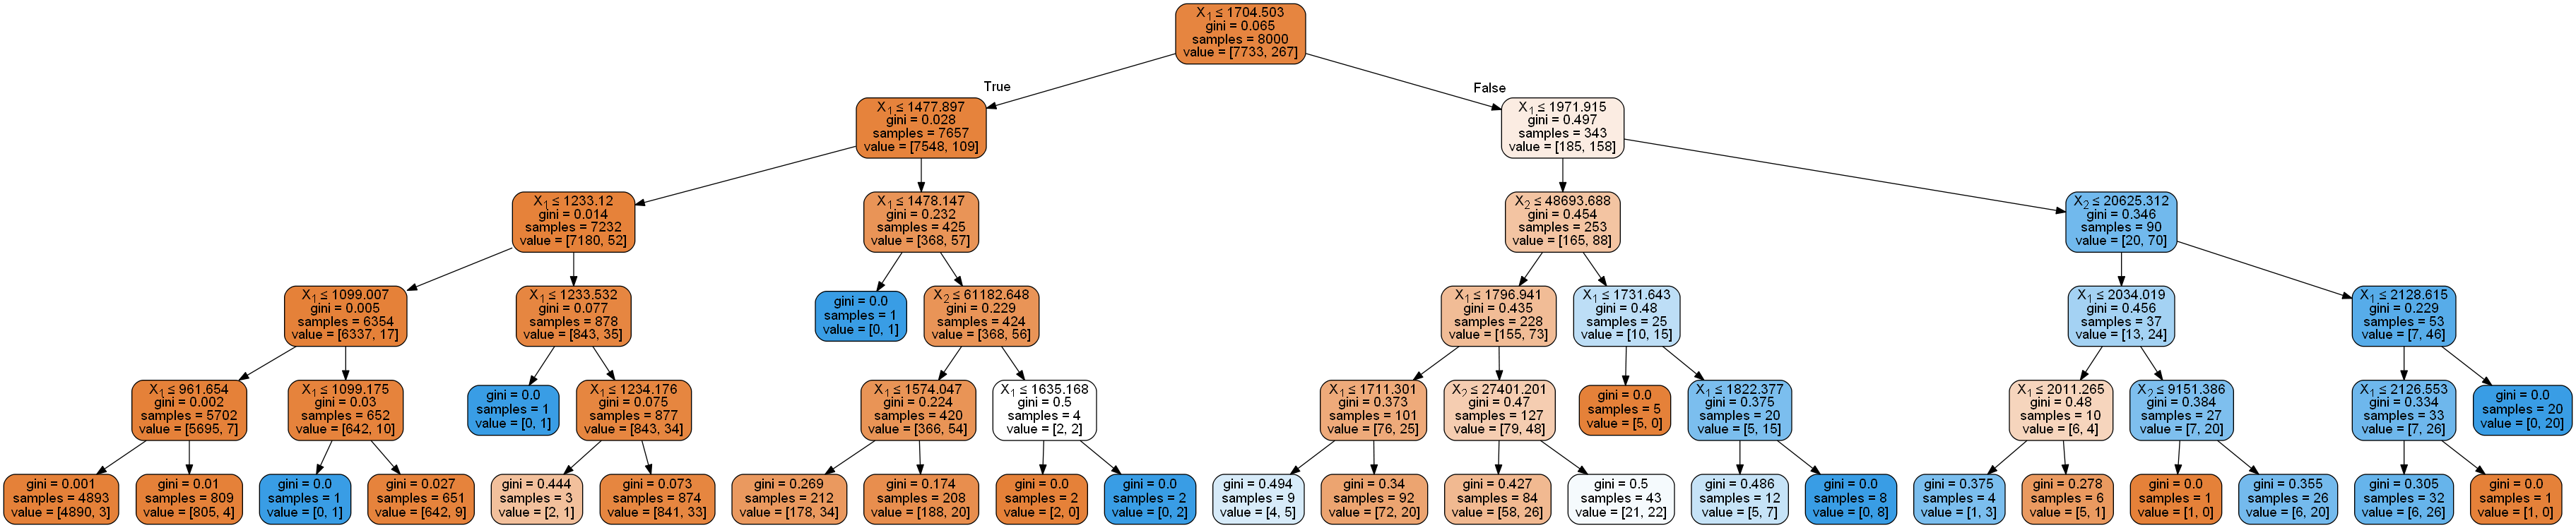

In [16]:
#Split data
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2)

#Train decision tree
clf = tree.DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, y_train)
dot_data = StringIO()

#Generate decision tree graph
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

8) Find the optimal decision tree depth and compute the AUC ROC.

Score for decision tree of depth 5 is: 0.9150214659521794


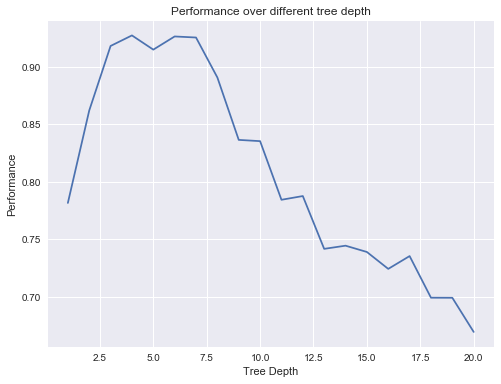

Optimized tree depth: 4.00
Optimized Performance Score AUC: 0.9274


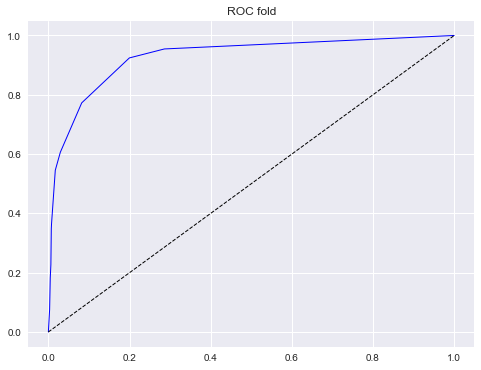

AUC = 0.9274


In [17]:
# Optimize the decision tree depth
tree_depths = range(20)+np.ones(20)
scores = []

for  tree_depth in tree_depths:
    clf = tree.DecisionTreeClassifier(max_depth = tree_depth)
    probas_ = clf.fit(X_train, y_train).predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    scores.append(auc(fpr, tpr))

print('Score for decision tree of depth 5 is:',scores[4])    
    
    
# Plot the figures
plt.plot(tree_depths,scores)
plt.xlabel('Tree Depth')
plt.ylabel('Performance')
plt.title('Performance over different tree depth')
plt.show()
optimal_depth = tree_depths[scores.index(max(scores))]
# Output the alphas with max score
print ('Optimized tree depth: %.2f' %optimal_depth)
print ('Optimized Performance Score AUC: %.4f' %scores[scores.index(max(scores))])

# Classification Tree
clf = tree.DecisionTreeClassifier(max_depth = optimal_depth)
clf = clf.fit(X_train,y_train)
score = clf.score(X_test, y_test)


# Plot ROC
optimal_dt = tree.DecisionTreeClassifier(max_depth=optimal_depth)
optimal_dt.fit(X_train, y_train)
fpr, tpr, thresholds, roc_auc = get_auc(X_test,y_test,optimal_dt)
plt.plot(fpr, tpr, lw=1, color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='black')
plt.title('ROC fold')
plt.show()
print( 'AUC = %0.4f' % (roc_auc))